<table style="width: 100%; border-style: none;">
<tr style="border-style: none">
<td style="border-style: none; width: 1%; font-size: 16px">Institut f&uuml;r Theoretische Physik<br /> Universit&auml;t zu K&ouml;ln</td>
<td style="border-style: none; width: 1%; font-size: 16px">&nbsp;</td>
<td style="border-style: none; width: 1%; text-align: right; font-size: 16px">Prof. Dr. Simon Trebst<br />Peter Br&ouml;cker</td>
</tr>
</table>
<hr>
<h1 style="font-weight:bold; text-align: center; margin: 0px; padding:0px;">Computerphysik</h1>
<h1 style="font-weight:bold; text-align: center; margin: 0px; padding:0px;">Vorlesung &mdash; Programmiertechniken 6</h1>
<hr>
<h3 style="font-weight:bold; text-align: center; margin: 0px; padding:0px; margin-bottom: 20px;">Sommersemester 2016</h3>

**Website:** [http://www.thp.uni-koeln.de/trebst/Lectures/2016-CompPhys.shtml](http://www.thp.uni-koeln.de/trebst/Lectures/2016-CompPhys.shtml)

## 1. Pakete in Julia

### Paketinstallation

Einbindung des <b>ODE.jl</b> Pakets zur Lösung von gewöhnlichen Differentialgleichungen

In [ ]:
Pkg.update()
Pkg.add("ODE")
using ODE

In [1]:
using PyCall
pygui(:tk)
using PyPlot
using LaTeXStrings

<hr/><br/>

## 2. Der Lorenz-Attraktor

Als erste Anwendung dieses Pakets wollen wir den Lorenz-Attraktor betrachten.

Für die Simulation eines einfachen **Wetter-Modells** hat der Meteorologe Edward Lorenz 1963 eine Beschreibung von 
Luftströmungen entworfen. Dazu hat er ein Gleichungssystem von drei gekoppelten Differentialgleichungen betrachtet:
\begin{align}
\frac{dx}{dt} &= a\left(y - x\right) \\
\frac{dy}{dt} &= x\left(b-z\right)-y\\
\frac{dz}{dt} &= x y - c z.
\end{align}  



In [2]:
using ODE

Für das ODE-Paket müssen wir nun die Differentialgleichug in der Form
\begin{align}
\frac{d \bf r}{dt} = {\bf f}(t, {\bf r})
\end{align}
schreiben. wobei ${\bf r}=(x,y,z)$ ist und die Funktion $\bf f$ die Differentialgleichung als Funktion der Zeit codiert.  

In [3]:
function f(t, r)
    # Extract the coordinates from the r vector
    (x, y, z) = r
    
    # The Lorenz equations
    dx_dt = a*(y - x)
    dy_dt = x*(b - z) - y
    dz_dt = x*y - c*z
    
    # Return the derivatives as a vector
    [dx_dt; dy_dt; dz_dt]
end;

Definieren wir die <b>Anfangsbedingungen</b>, Konstanten und das Diskretisierungs-Schema der Zeitintegration

In [4]:
# Define time vector and interval grid
const dt = 0.001
const tf = 100.0
t = 0:dt:tf

# Initial position in space
const r0 = [0.1; 0.0; 0.0]

# Constants sigma, rho and beta
const a = 10.0
const b = 28.0
const c = 8.0/3.0;

Damit können wir nun das ODE-Paket nutzen, um die Differentialgleichung zu lössen

In [5]:
(t, pos) = ode45(f, r0, t);

Lesen wir das Ergebnis aus, und plotten es.

In [6]:
x = map(v -> v[1], pos)
y = map(v -> v[2], pos)
z = map(v -> v[3], pos);

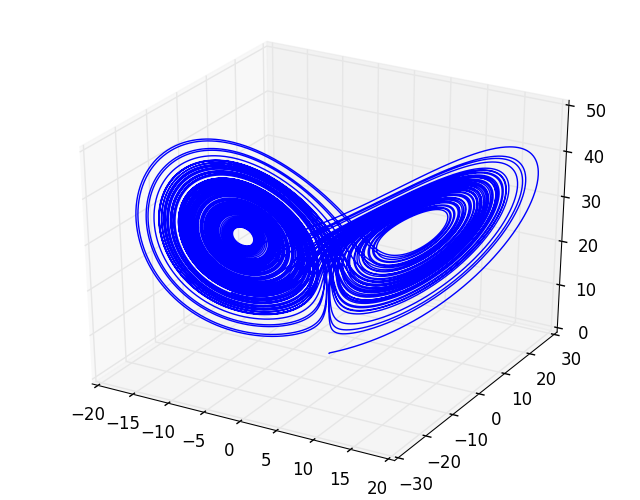

In [7]:
using PyPlot
plot3D(x, y, z);

Schauen wir uns das noch aus verschiedenen Perspektiven an.

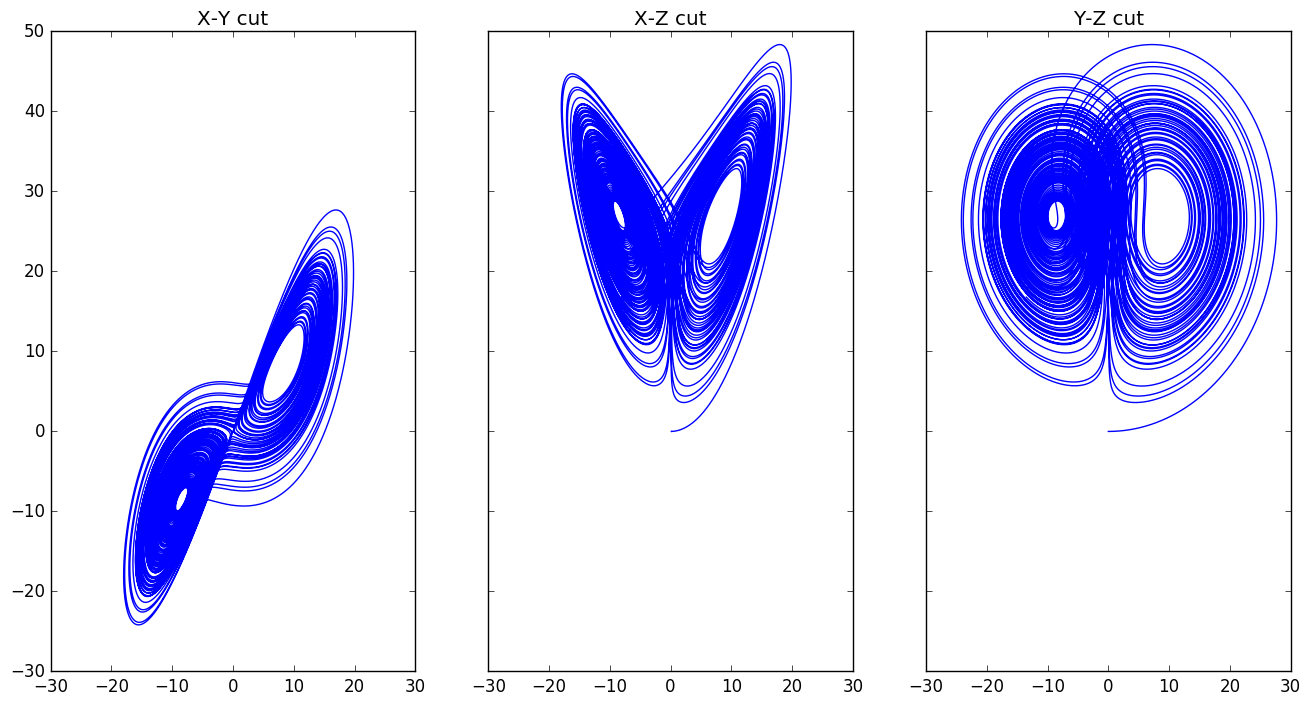

In [8]:
fig, ax = subplots(1, 3, sharex=true, sharey=true, figsize=(16,8))

ax[1][:plot](x, y)
ax[1][:set_title]("X-Y cut")

ax[2][:plot](x, z)
ax[2][:set_title]("X-Z cut")

ax[3][:plot](y, z)
ax[3][:set_title]("Y-Z cut");

<hr/><br/>

## 3. Das Pohlsche Rad

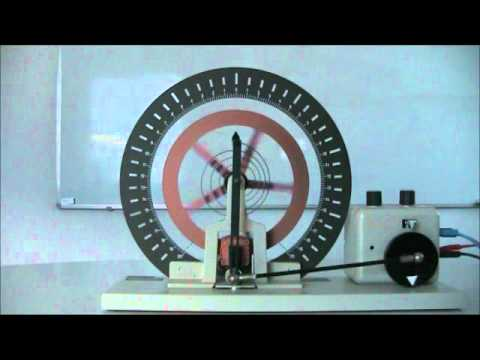

In [1]:
using PyCall
@pyimport IPython.display as my_display
my_display.YouTubeVideo("5lzLZcIBhlg",width=800,height=450)

Das [Pohlsche Rad](https://de.wikipedia.org/wiki/Pohlsches_Rad) ist ein getriebenes und gleichzeitig gedämpftes Federpendel, an dem sich alle grundlegenden Schwingungsphänomene studieren lassen. Beschrieben wird dieses Pendel durch die Gleichung

\begin{equation}
m \dfrac{d^2x}{dt^2} + b\dfrac{dx}{dt}+k \sin(x) = F(t)
\end{equation}

beziehungsweise umgestellt

\begin{equation}
\dfrac{d^2x}{dt^2} + \dfrac{b}{m} \dfrac{dx}{dt}+\dfrac{k}{m} \sin(x) = \dfrac{1}{m}F(t)
\end{equation}

### Verwendung von ODE.jl

Die zu bearbeitende DGL muss umgeschrieben werden in eine DGL erster Ordnung. Übergeben wird der Funktion die aktuelle Zeit $t$ und dann als Vektor die Gleichungen. in unserem Fall sind die Einträge
\begin{align}
\dot{x} &= v\\
\dot{v} &= -\frac{k}{m} \sin x - \frac{b}{m} v + F \sin{(\omega * t)}\\
\end{align}
so dass $\ddot{x}$ genau der Beschleunigung entspricht.

In [2]:
using ODE
using PyCall
pygui(:tk)
using PyPlot
using LaTeXStrings
pygui(false)

false

In [3]:
function oscillator(t, y)
    # Zerlege den Vektor
    (x, v) = y
    # gebe neuen Vektor zurueck
    return [v; - k/m * sin(x) - b/m * v + F * sin(omega * t)]
end

oscillator (generic function with 1 method)

Als erstes Beispiel betrachten wir den Resonanzfall.

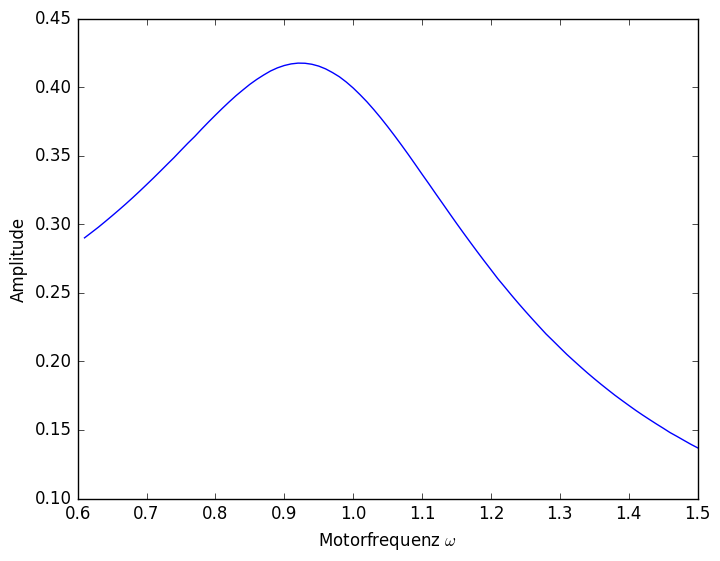

PyObject <matplotlib.text.Text object at 0x3173dad10>

In [4]:
# physikalische Konstanten
m = 1.
b = 0.5
k = 1
F = 0.2 # * m

# Amplituden
amplitudes = Float64[]

omegas = vcat(0.61:0.01:1.5)
omega = 0
for omega in omegas
    
    # Anfangsbedingungen
    initial = [0.2; 0.0]
    
    # Aufruf: Funktionensystem, Anfangsbedingung, Integrationszeitraum
    T, xv = ode45(oscillator, initial, 1:0.1:500);
    
    xv = hcat(xv...)'
    amp = maximum(xv[end - 200:end, 1])

    push!(amplitudes, amp)
end

plot(omegas, amplitudes)
xlabel(L"Motorfrequenz $\omega$")
ylabel("Amplitude")

### Portrait des Phasenraums 

Wir starten den Oszillator nahe der Resonanz und beobachten zunächst den Einschwingvorgang als stetige Vergrößerung der Amplitude bis schließlich die periodische Bewegung im Phasenraum erreicht wird.

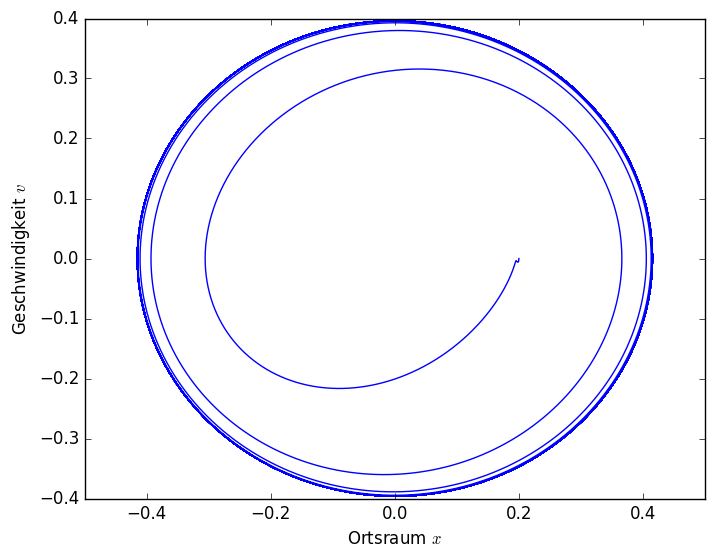

PyObject <matplotlib.text.Text object at 0x306268510>

In [5]:
omega = 0.95
initial = [0.2, 0.0]
T, xv = ode45(oscillator, initial, 1:0.01:500);

xv = hcat(xv...)'
xs = xv[:, 1]
vs = xv[:, 2]

plot(xs, vs)
xlabel(L"Ortsraum $x$")
ylabel(L"Geschwindigkeit $v$")

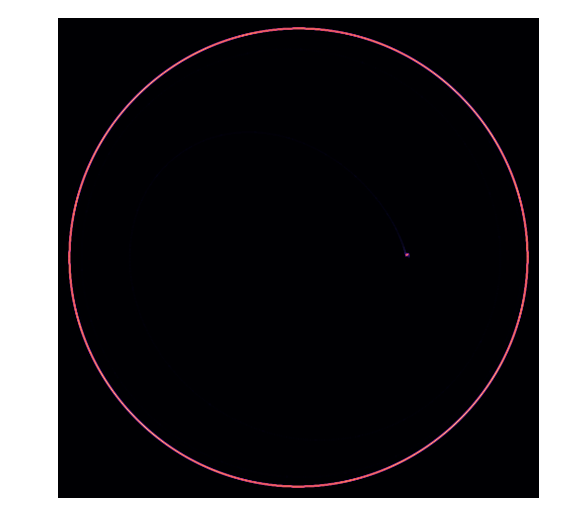

(-0.5,999.5,999.5,-0.5)

In [6]:
width = 1000
height = 1000

min_x, max_x, min_y, max_y = minimum(xs)*1.05, maximum(xs)*1.05, minimum(vs) * 1.05, maximum(vs) * 1.05
x_width = max_x - min_x
y_width = max_y - min_y

xy = zeros(height, width)
for (x, y) in zip(xs, vs)
    im_x = min(width, max(1, Int(ceil((x - min_x) * width / x_width))))
    im_y = min(height, max(1, Int(ceil((y - min_y) * height / y_width))))
    
    w = 2
    x_range = max(1, im_x - w):min(width, im_x + w)
    y_range = max(1, im_y - w):min(height, im_y + w)
    
    xy[im_y, im_x] += 1
    xy[y_range, x_range] += 1    
end

imshow(xy, cmap="magma")
axis("off")

### Mit Bifurkation und 2 Poincare Punkten

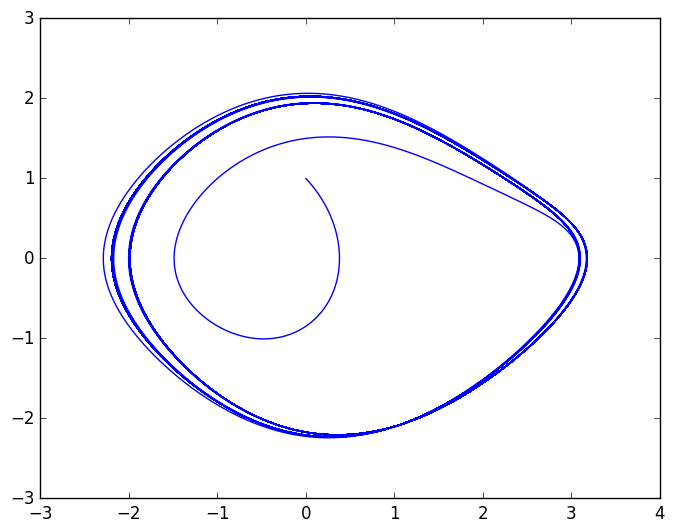

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3217036d0>

In [7]:
F = -1.07
m = 1
k = 1.
b = 0.5

omega = 2./3
initial = [0.0; 1.0]
T, xv = ode45(oscillator, initial, 1:0.01:500);

xv = hcat(xv...)'
xs = xv[:, 1]
vs = xv[:, 2]

plot(xs, vs)

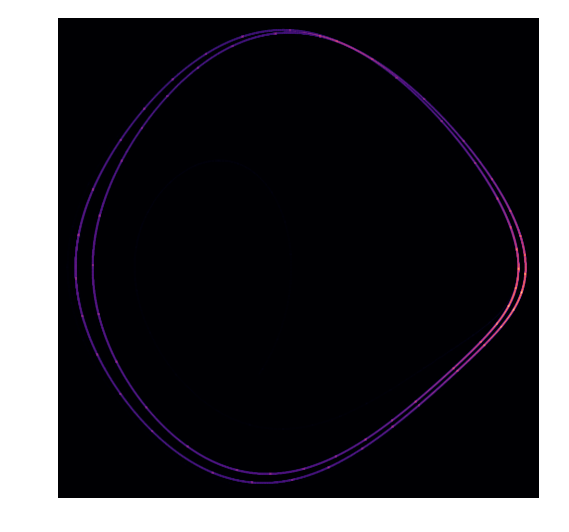

(-0.5,999.5,999.5,-0.5)

In [8]:
pygui(false)

width = 1000
height = 1000

min_x, max_x, min_y, max_y = minimum(xs)*1.05, maximum(xs)*1.05, minimum(vs) * 1.05, maximum(vs) * 1.05
x_width = max_x - min_x
y_width = max_y - min_y

xy = zeros(height, width)
for (x, y) in zip(xs, vs)
    im_x = min(width, max(1, Int(ceil((x - min_x) * width / x_width))))
    im_y = min(height, max(1, Int(ceil((y - min_y) * height / y_width))))
    
    w = 2
    x_range = max(1, im_x - w):min(width, im_x + w)
    y_range = max(1, im_y - w):min(height, im_y + w)
    
    xy[im_y, im_x] += 1
    xy[y_range, x_range] += 1    
end

imshow(xy, cmap="magma")
axis("off")

In [ ]:
F = -1.07
m = 1
k = 1.
b = 0.5

omega = 2./3
initial = [0.0; 1.0]
T, xv = ode45(oscillator, initial, 1:0.01:500);

xv = hcat(xv...)'
xs = xv[:, 1]
vs = xv[:, 2]

pygui(true)
plot(xs, vs)

p = plot(xs[1], vs[1], "o")[1]

for (i, t) in enumerate(collect(1:0.01:500))
    if mod(i,10)!=0 continue end
    p[:set_data](xs[i], vs[i])
    sleep(0.01)


end

### Chaos

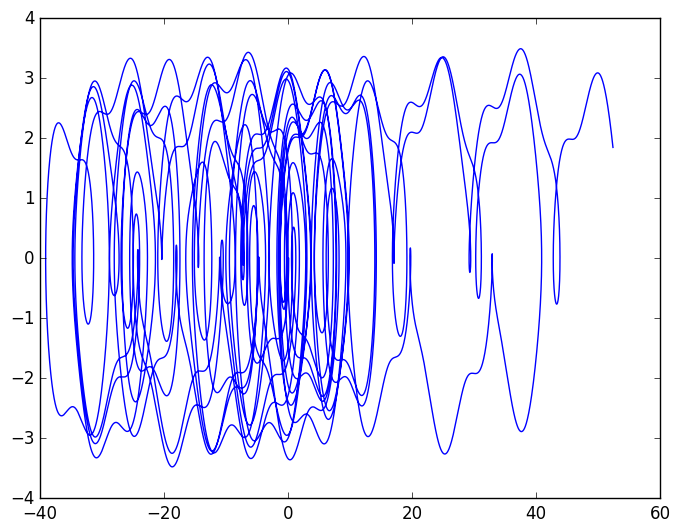

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32339ce10>

In [9]:
F = -1.47
m = 1
k = 1.
b = 0.25

omega = 2./3
initial = [0.1; 0.0]
T, xv = ode45(oscillator, initial, 1:0.01:500);

xv = hcat(xv...)'
xs = xv[:, 1]
vs = xv[:, 2]

plot(xs, vs)

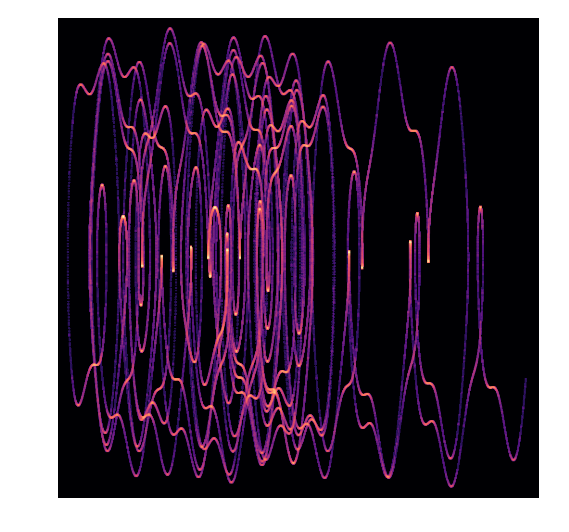

(-0.5,999.5,999.5,-0.5)

In [10]:
width = 1000
height = 1000

min_x, max_x, min_y, max_y = minimum(xs)*1.05, maximum(xs)*1.05, minimum(vs) * 1.05, maximum(vs) * 1.05
x_width = max_x - min_x
y_width = max_y - min_y

xy = zeros(height, width)
for (x, y) in zip(xs, vs)
    im_x = min(width, max(1, Int(ceil((x - min_x) * width / x_width))))
    im_y = min(height, max(1, Int(ceil((y - min_y) * height / y_width))))
    
    w = 2
    x_range = max(1, im_x - w):min(width, im_x + w)
    y_range = max(1, im_y - w):min(height, im_y + w)
    
    xy[im_y, im_x] += 1
    xy[y_range, x_range] += 1    
end

for r in 1:height
    for c in 1:width
        if xy[r, c] == 0 continue end
        xy[r, c] = log(xy[r, c])
    end
end

imshow(xy, cmap="magma")
axis("off")

<hr/><br/>
## 4. Dancing with the stars

Zum Abschluss wollen wir noch **Sterne** zum **Tanzen** bringen.

Hierzu untersuchen wir ein System aus $n$ Massen, die sich gravitativ nach dem Gesetz
\begin{equation}
F_{12} = -Gm_1m_2\dfrac{\vec{r}_1 - \vec{r}_2}{r^3}
\end{equation}
anziehen.
Die Gravitationskonstante sowie alle Massen setzen wir auf $1$.

Wir wollen zwei, dreo verschiedene Systeme simulieren, deren Anfangswerte wie folgt gegeben seien:

#### 3 Körper
\begin{aligned}
\vec{x}_1 &= (0.97000436, -0.24308753) \\
\vec{x}_2 &= - \vec{x}_1  \\
\vec{x}_3 &= (0, 0) 
\end{aligned}

\begin{aligned}
\vec{v}_1 &= ( 0.466203685, 0.43236573 )\\
\vec{v}_2 &= \vec{v}_1\\
\vec{v}_3 &= -2\vec{v}_1
\end{aligned}

Dieses System ist das einzige *stabile*, d.h.kleine Ungenauigkeiten in der Integration beeinflussen das Ergebnisse nicht stark und die Dynamik bleibt über lange Zeiten stabil. Die mathematisch Interessierten unter Ihnen finden die Herleitung dieses stabilen $3$-Körper-Systems  in (diesem Artikel)[http://arxiv.org/pdf/math/0011268.pdf] aus dem Jahre 2000. 

#### 4 Körper

\begin{aligned}
\vec{x}_1 &= (1.382857, 0) \\
\vec{x}_2 & = (0, 0.157030) \\
\vec{x}_3 &= -\vec{x}_1\\
\vec{x}_4 & = -\vec{x}_2 \\
\end{aligned}

\begin{aligned}
\vec{v}_1 &= (0, 0.584873) \\ 
\vec{v}_2 &= (1.871935, 0) \\
\vec{v}_3 &= -\vec{v}_1 \\
\vec{v}_4 &= -\vec{v}_2
\end{aligned}

#### 5 Körper

\begin{aligned}
\vec{x}_1 &= (0.439775, -0.169717) \\
\vec{x}_2 &= (-1.268608, -0.267651) \\
\vec{x}_3 &= (-1.268608, 0.267651) \\
\vec{x}_4 &= (0.439775, 0.169717) \\
\vec{x}_5 &= -\sum_{i=1}^4 \vec{x}_i \\
\end{aligned}

\begin{aligned}
\vec{v}_1 &= (1.822785, 0.128248) \\
\vec{v}_2 &= (1.271564, 0.168645) \\
\vec{v}_3 &= (-1.271564, 0.168645) \\
\vec{v}_4 &= (-1.822785, 0.128248) \\
\vec{v}_5 &= -\sum_{i=1}^4 \vec{v}_i \\
\end{aligned}

In [ ]:
using ODE
using PyCall
pygui(:tk)
using PyPlot
using LaTeXStrings

In [ ]:
function flow(t, y)
    N = div(length(y), 4)
    return_vec = zeros(4 * N)
    
    # Zerlege den Vektor
    xs = y[1:N]
    ys = y[N+1 : 2*N]
    
    v_xs = y[2 * N + 1:3 * N]        
    v_ys = y[3 * N + 1:4 * N]
    return_vec[1:N] = v_xs
    return_vec[N + 1:2*N] = v_ys
    
    for i in 1:N
        for j in 1:N
            if i == j continue end
            r = sqrt((xs[i] - xs[j])^2 + (ys[i] - ys[j])^2)
            return_vec[2 * N + i] += - (xs[i] - xs[j]) / r^3
            return_vec[3 * N + i] += - (ys[i] - ys[j]) / r^3
        end
    end

    return return_vec
end

### 3 Körper

In [ ]:
ts = 1.0:0.005:100

initial_xs = [0.97000436, -0.97000436, 0.]
initial_ys = [-0.24307853, 0.24307853, 0.]
initial_v_xs = [0.466203685, 0.466203685, -2 * 0.466203685]
initial_v_ys = [0.43236573, 0.43236573, -2 * 0.43236573]
initial = [initial_xs; initial_ys; initial_v_xs; initial_v_ys]

# call ODE package
(T, xv) = ode78(flow, initial, ts)

xv = hcat(xv...)'
x1s = xv[:, 1]
x2s = xv[:, 2]
x3s = xv[:, 3]
y1s = xv[:, 4]
y2s = xv[:, 5]
y3s = xv[:, 6];

In [ ]:
pygui(true)

figure(facecolor="white")
plot(x1s[:], y1s[:], color="#999999", linewidth=0.8)

p1 = plot(x1s[1], y1s[1], "o", markeredgecolor="none", markersize=20)[1]
p2 = plot(x2s[1], y2s[1], "o", markeredgecolor="none", markersize=20)[1]
p3 = plot(x3s[1], y3s[1], "o", markeredgecolor="none", markersize=20)[1]

xlim([minimum([x1s; x2s; x3s]) * 1.1, maximum([x1s; x2s; x3s]) * 1.1])
ylim([minimum([y1s; y2s; y3s]) * 1.1, maximum([y1s; y2s; y3s]) * 1.1])
axis("off")
for (i, t) in enumerate(ts)
    p1[:set_data](x1s[i], y1s[i])
    p2[:set_data](x2s[i], y2s[i])
    p3[:set_data](x3s[i], y3s[i])
    sleep(0.001)
end

### 4 Körper

In [ ]:
ts = 1.0:0.001:100

initial_xs = [1.382857, 0., -1.382857, 0.]
initial_ys = [0., 0.157030, 0., -0.157030]
initial_v_xs = [0, 1.871935, 0, -1.871935]
initial_v_ys = [0.584873, 0., -0.584873, 0.]
initial = [initial_xs; initial_ys; initial_v_xs; initial_v_ys]
(T, xv) = ode78(flow, initial, ts)

xv = hcat(xv...)'
x1s = xv[:, 1]
x2s = xv[:, 2]
x3s = xv[:, 3]
x4s = xv[:, 4]
y1s = xv[:, 5]
y2s = xv[:, 6]
y3s = xv[:, 7]
y4s = xv[:, 8];

In [ ]:
pygui(true)

figure(facecolor="white")
plot(x1s[1:10000], y1s[1:10000], color="#999999", linewidth=0.8)

p1 = plot(x1s[1], y1s[1], "o", markeredgecolor="none", markersize=20)[1]
p2 = plot(x2s[1], y2s[1], "o", markeredgecolor="none", markersize=20)[1]
p3 = plot(x3s[1], y3s[1], "o", markeredgecolor="none", markersize=20)[1]
p4 = plot(x4s[1], y4s[1], "o", markeredgecolor="none", markersize=20)[1]

# xlim([minimum([x1s; x2s; x3s; x4s]) * 1.1, maximum([x1s; x2s; x3s; x4s]) * 1.1])
# ylim([minimum([y1s; y2s; y3s; y4s]) * 1.1, maximum([y1s; y2s; y3s; y4s]) * 1.1])
axis("off")
for (i, t) in enumerate(ts)
    p1[:set_data](x1s[i], y1s[i])
    p2[:set_data](x2s[i], y2s[i])
    p3[:set_data](x3s[i], y3s[i])
    p4[:set_data](x4s[i], y4s[i])
    sleep(0.00001)
end